# Signal extraction: FGS1

Now, let's do the same trick with the FGS1 data. This will be a little different, we can extract both rows and columns and then sum the signal pixels down to a single number for the one wavelength index covered by the FGS1 camera.

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
from pathlib import Path

# Third party imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

# Local imports
import configuration as config

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/signal_extraction'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

config.COLORMAP

# Define sample frame for analysis
sample_frame = 3

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Load test frame

In [2]:
# Load corrected data from HDF5 file
with h5py.File(f'{config.SIGNAL_CORRECTED_DIRECTORY}/train.h5', 'r') as hdf:
    fgs_frames = hdf[config.SAMPLE_PLANET]['FGS1_signal'][:]

print(f'Data shape: {fgs_frames.shape}')

Data shape: (5625, 32, 32)


Looks like we are loosing the pixel mask when we save the data to HDF5. See NumPy docks on [masked arrays](https://numpy.org/doc/1.21/user/tutorial-ma.html).

## 2. Total flux by frame y-index

In [3]:
# Sum the frame's rows
frame_row_sums = np.sum(fgs_frames[sample_frame], axis=1)

# Sum the frame's columns
frame_col_sums = np.sum(fgs_frames[sample_frame], axis=0)

# Standardize the sums
frame_row_sums = (frame_row_sums - np.mean(frame_row_sums)) / np.std(frame_row_sums)
frame_col_sums = (frame_col_sums - np.mean(frame_col_sums)) / np.std(frame_col_sums)

Wow, well, that's an interesting result right there - the corrected frame looks cleaner as an image, but after standardization the total signal across rows is almost identical to the uncorrected frame.

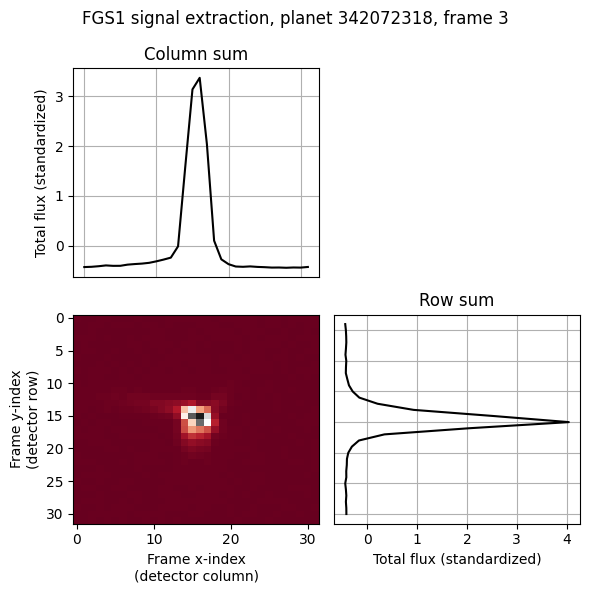

In [4]:
fig = plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH ))

fig.suptitle(f'FGS1 signal extraction, planet {config.SAMPLE_PLANET}, frame {sample_frame}')

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.set_title('Column sum')
ax1.plot(
    range(len(frame_col_sums)),
    frame_col_sums,
    color='black'
)

ax1.set_ylabel('Total flux (standardized)')
ax1.xaxis.set_ticks_position('none')     # Remove x-axis tick marks
ax1.set_xticklabels([])                  # Remove x-axis tick labels
ax1.grid()

# ax2.set_title(f'AIRS-CH0 signal')
ax2.imshow(fgs_frames[sample_frame], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
ax2.set_xlabel('Frame x-index\n(detector column)')
ax2.set_ylabel('Frame y-index\n(detector row)')

ax3.set_title('Row sum')
ax3.plot(
    frame_row_sums,
    range(len(frame_row_sums)),
    color='black'
)
ax3.set_xlabel('Total flux (standardized)')
ax3.yaxis.set_ticks_position('none')     # Remove y-axis tick marks
ax3.set_yticklabels([])                  # Remove y-axis tick labels
ax3.grid()

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.4.3-total_flux_by_row_spectrogram.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)

The part of the frame that actually contains the signal is clearly between pixels 10 and 20 on both axes. The highest signal rows look like 14, 15, 16 and 17 on their respective axes.

## 3. Signal 'block': brightest rows & columns

Similarly to the AIRS_CH0 data, let's get the top few rows, then the top few columns and sum them.

In [5]:
n_rows = 6

# Sum across the row and column axes
row_sums = np.sum(fgs_frames, axis=2)
col_sums = np.sum(fgs_frames, axis=1)

# Get top n rows and columns for each frame
top_rows = np.argsort(row_sums, axis=1)[:, -n_rows:]
top_cols = np.argsort(col_sums, axis=1)[:, -n_rows:]

# Now index the original array to get the top rows for each frame
signal_strip = fgs_frames[:, top_rows[1], :]

# And then the top columns for each frame
signal_block = signal_strip[:, :, top_cols[1]]

# Sum the block per frame
signal = np.sum(signal_strip, axis=1)
signal = np.sum(signal, axis=1)

# Calculate total flux for each frame
total_flux = [np.sum(frame) for frame in fgs_frames]

In [6]:
signal.shape

(5625,)

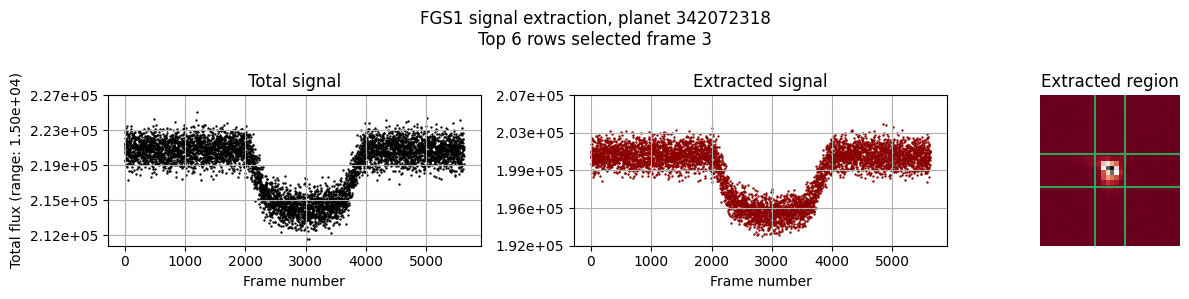

In [7]:
fig = plt.figure(figsize=(config.STD_FIG_WIDTH * 2, config.STD_FIG_WIDTH/2))

fig.suptitle(f'FGS1 signal extraction, planet ' +
    f'{config.SAMPLE_PLANET}\nTop {n_rows} rows selected frame {sample_frame}')

gs = fig.add_gridspec(1,5)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2:4])
ax3 = fig.add_subplot(gs[4])

ax1.set_title(f'Total signal')

ax1.scatter(
    list(range(len(total_flux))),
    total_flux,
    color='black',
    s=0.5
)

ax1.set_xlabel('Frame number')

y_lims = ax1.get_ylim()
y_range = y_lims[1] - y_lims[0]
data_mean = np.mean(total_flux)
y_start = data_mean - y_range/2
y_end = data_mean + y_range/2

ax1.set_yticks(np.round(np.linspace(y_start, y_end, 5), 2))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax1.set_ylabel(f'Total flux (range: {y_range:.2e})')
ax1.grid()

ax2.set_title(f'Extracted signal')

ax2.scatter(
    list(range(len(signal))),
    signal,
    color='darkred',
    s=0.5
)

ax2.set_xlabel('Frame number')
ax2.grid()

data_mean = np.mean(signal)
y_start = data_mean - y_range/2
y_end = data_mean + y_range/2

ax2.set_yticks(np.linspace(y_start, y_end, 5))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

ax3.set_title(f'Extracted region')
ax3.imshow(fgs_frames[sample_frame], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
ax3.axhline(y=np.max(top_rows[0]) + 1, color=config.GREEN, linestyle='-')
ax3.axhline(y=np.min(top_rows[0]) - 1, color=config.GREEN, linestyle='-')
ax3.axvline(x=np.max(top_cols[0]) + 1, color=config.GREEN, linestyle='-')
ax3.axvline(x=np.min(top_cols[0]) - 1, color=config.GREEN, linestyle='-')
ax3.axis('off')
fig.tight_layout()

fig.savefig(
    f'{figures_dir}/02.4.4-transit_plot_total_vs_strip.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight')

Looks great. Transit signature is almost identical. Signal is slightly lower, just like the AIRS-CH0 data. Taking 4x4 or 6x6 pixel square seems to the the sweet spot. This preserves the signal with a 98% reduction in data. We can select the columns and rows the same way we did for the AIRS-CH0 data. I think I've seen enough, let's add it to the data pre-processing package.